In [17]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss
from keras import backend as K
K.set_image_dim_ordering('th')

In [13]:
import h5py
f = h5py.File("dataset.h5")
x = f['x'].value
y = f['y'].value
f.close()
x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)

In [32]:
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

x_train /= 255
x_test /= 255

In [23]:
model = Sequential()
model.add(Convolution2D(32, kernel_size=(3, 3),padding='same',input_shape=(3 , 100, 100)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('sigmoid'))


In [33]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1600, 3, 100, 100)
(400, 3, 100, 100)
(1600, 5)
(400, 5)


In [34]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.load_weights("weights.hdf5")
# check = ModelCheckpoint("weights.{epoch:02d}-{val_acc:.5f}.hdf5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
# model.fit(x_train, y_train, batch_size=32, epochs=20,callbacks=[check],validation_data=(x_test,y_test))

In [35]:
out = model.predict_proba(x_test)
out = np.array(out)

400/400 [==============================] - 33s    


In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 100, 100)      896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 100, 100)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 98, 98)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 32, 98, 98)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 49, 49)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 49, 49)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 49, 49)        18496     
__________

In [40]:
out

array([[  5.25076203e-02,   3.81865650e-01,   7.11545348e-01,
          3.03906891e-02,   2.52192736e-01],
       [  5.26889190e-02,   9.62114485e-04,   2.93579310e-01,
          9.72158492e-01,   5.14680594e-02],
       [  3.49882767e-02,   3.71032394e-03,   5.97689509e-01,
          9.70311403e-01,   2.65014009e-03],
       ..., 
       [  1.75322279e-01,   4.29682294e-03,   3.18148553e-01,
          9.09448683e-01,   3.30147445e-02],
       [  4.86279791e-03,   5.00628464e-02,   5.54790735e-01,
          3.92153254e-03,   4.14285213e-01],
       [  3.66324298e-02,   5.57558119e-01,   4.78138864e-01,
          7.09356973e-03,   2.37569913e-01]], dtype=float32)

In [42]:
threshold = np.arange(0.1,0.9,0.1)

acc = []
accuracies = []
best_threshold = np.zeros(out.shape[1])
for i in range(out.shape[1]):
    y_prob = np.array(out[:,i])
    for j in threshold:
        y_pred = [1 if prob>=j else 0 for prob in y_prob]
        acc.append( matthews_corrcoef(y_test[:,i],y_pred))
    acc   = np.array(acc)
    index = np.where(acc==acc.max()) 
    accuracies.append(acc.max()) 
    best_threshold[i] = threshold[index[0][0]]
    acc = []

In [46]:
print(best_threshold)
y_pred = np.array([[1 if out[i,j]>=best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

[ 0.6  0.3  0.5  0.3  0.7]


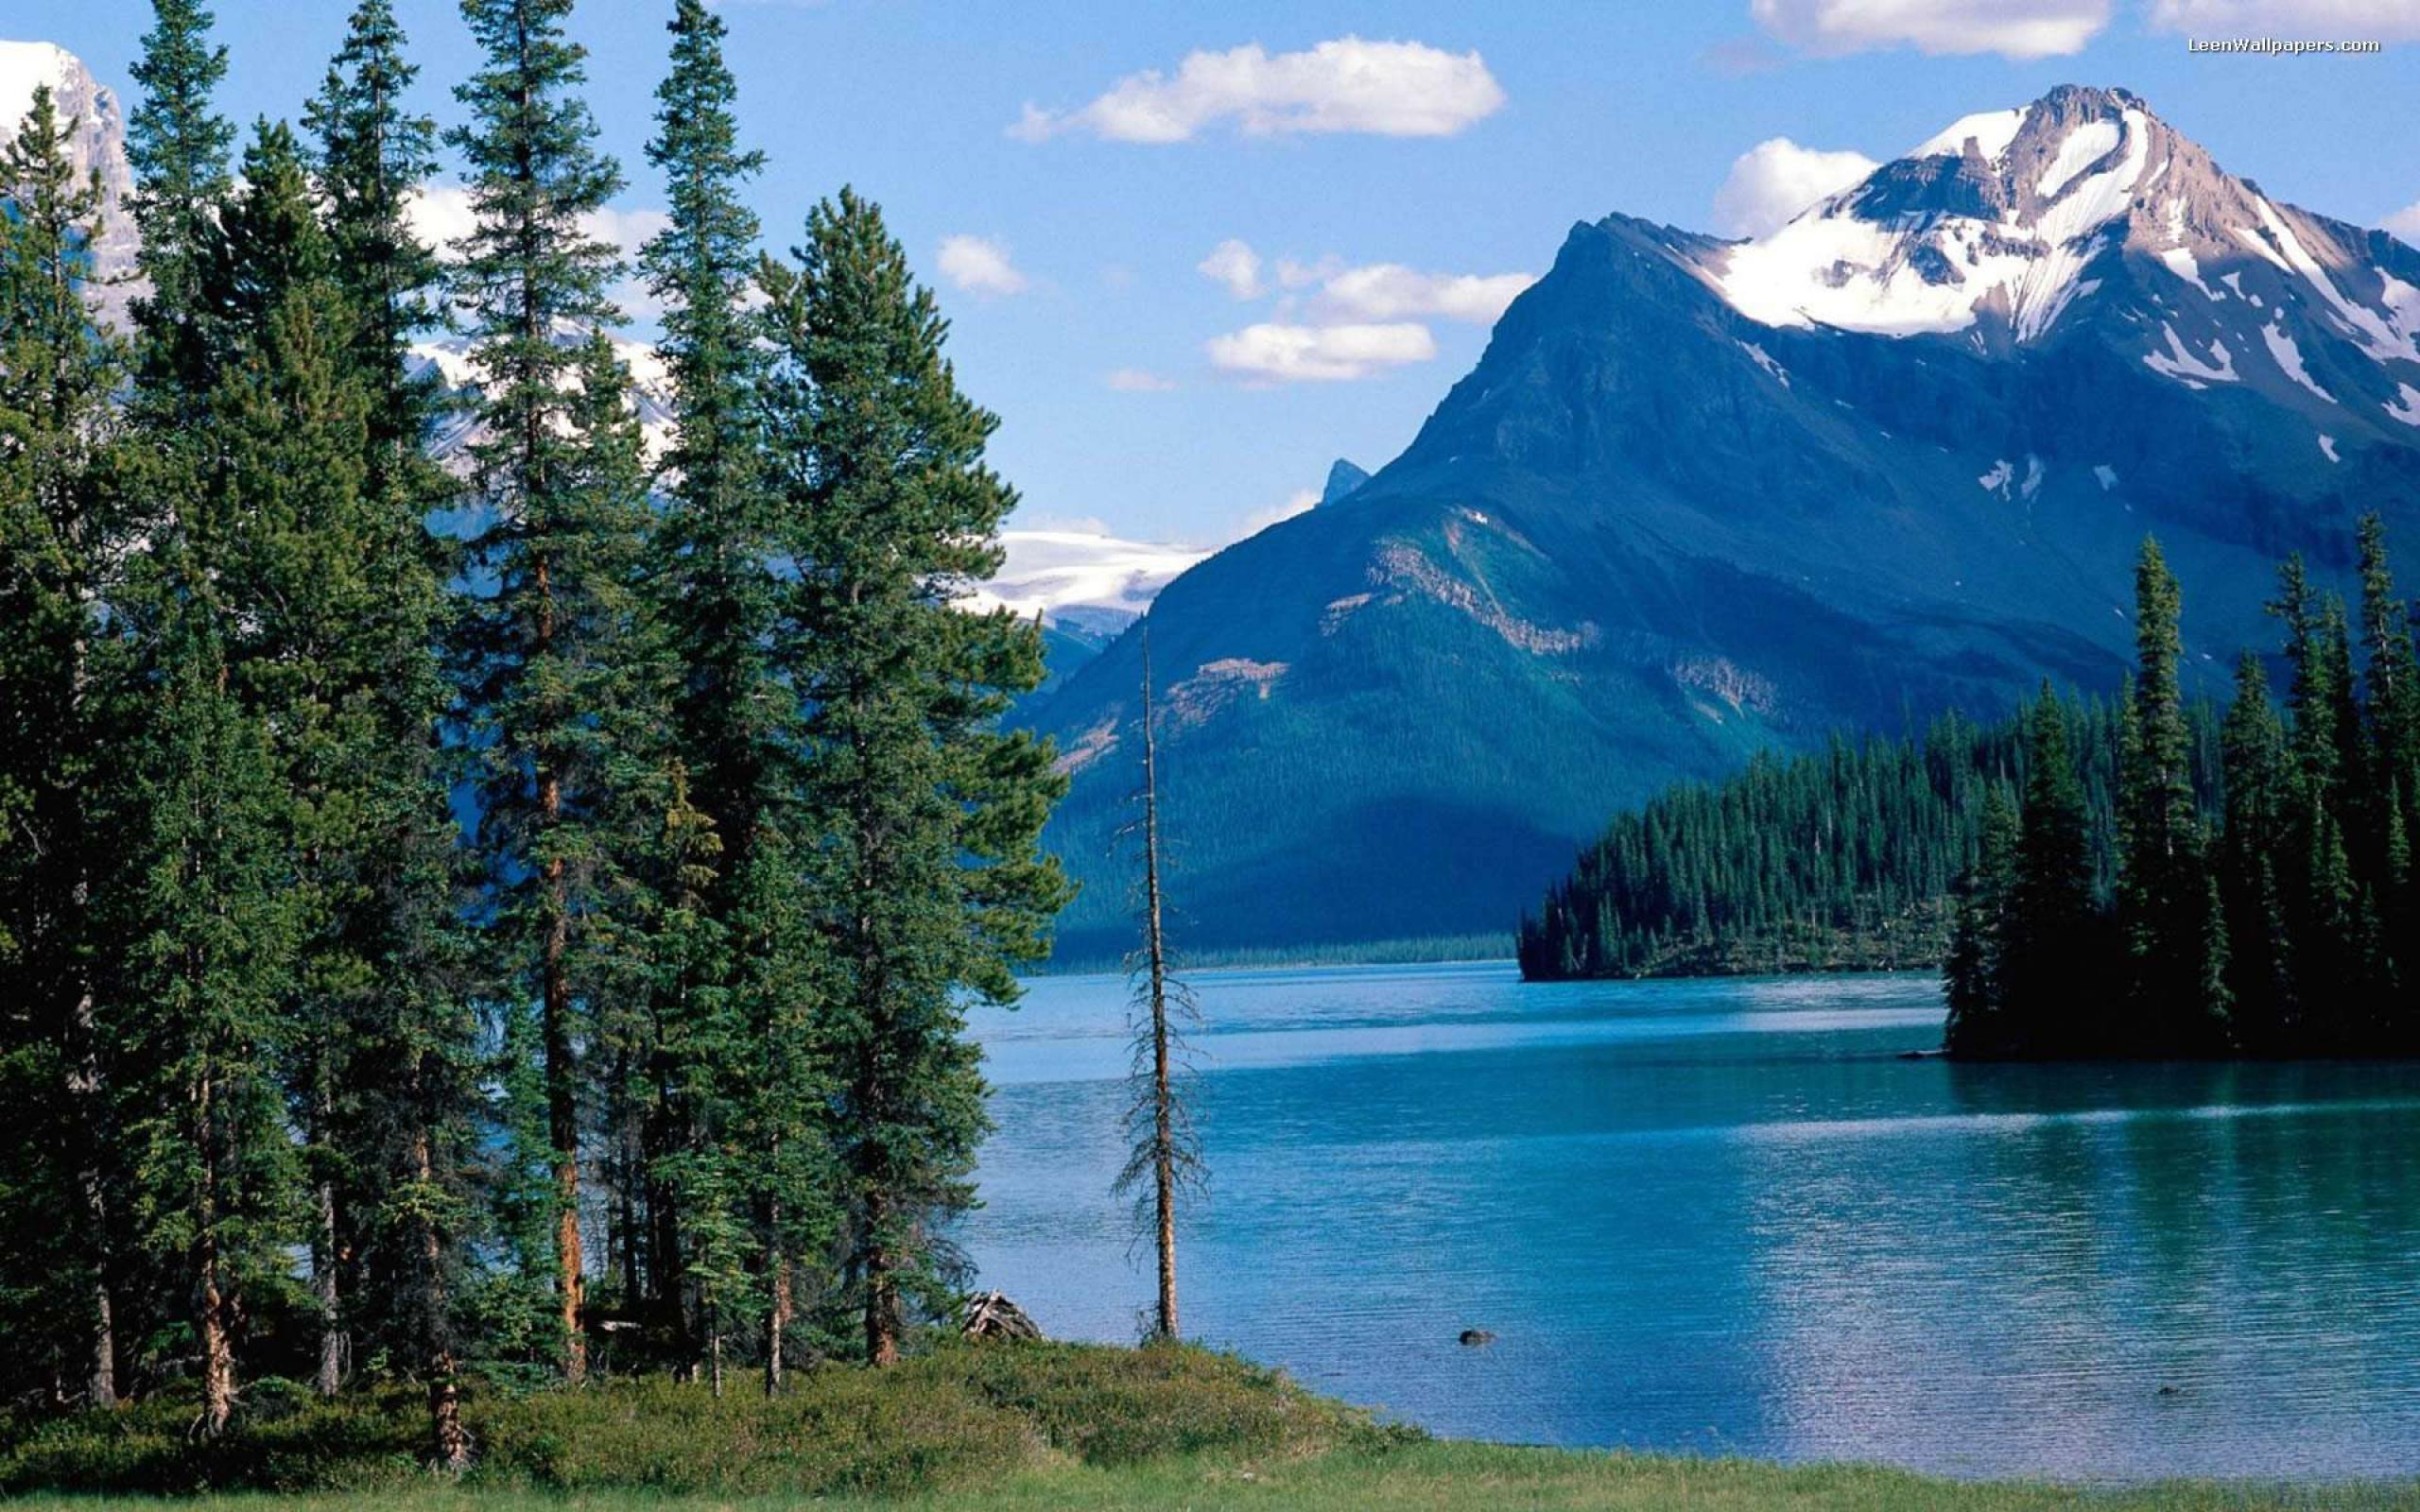

In [48]:
from IPython.display import Image
Image(filename='test_image.jpg')

In [58]:
import cv2
import os
image_name="test_image.jpg"
image_path=os.path.join(os.getcwd(),image_name)
print(image_path)
img=cv2.imread(image_path)
# img.shape
img=cv2.resize(img,(100,100))
img = img.transpose((2,0,1))
# img.shape   
img = img.astype('float32')
img = img/255
img = np.expand_dims(img,axis=0)

/Users/ashu/Desktop/mlai/hash_tag/test_image.jpg


(3, 100, 100)